# Compute Timelags: Cooling

In [1]:
import os
import sys

import numpy as np
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACube,AIATimelags
from synthesizAR.visualize import bgry_004_idl_cmap

%matplotlib inline

Spin up a Dask distributed cluster.

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43798 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Load the data and write it to a single HDF5 file. This makes data access later on much easier.

In [3]:
channels = [94,131,171,193,211,335]

In [4]:
tl = AIATimelags(*[DistributedAIACube.from_files(
    [f'/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA/{c}/map_t{i:06d}.fits' 
     for i in range(0,1000)]) for c in channels])

Plot a pixel-averaged light curve from the data we loaded.

In [5]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

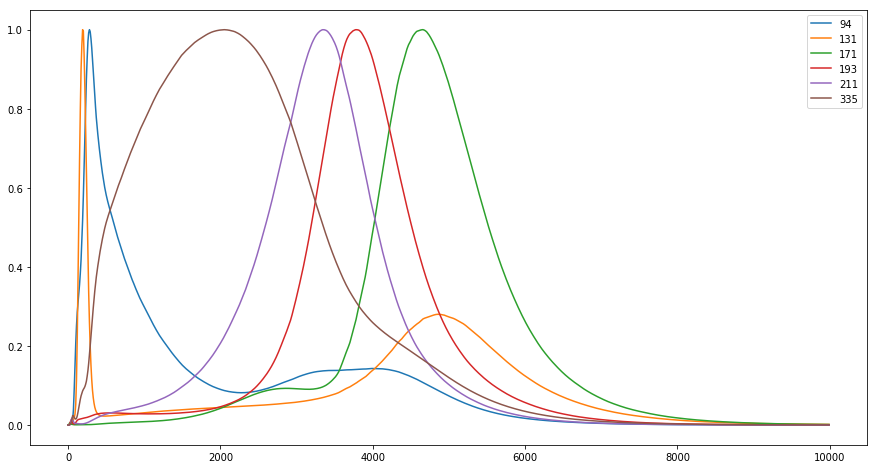

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for i,channel in enumerate(channels,):
    ts = tl.make_timeseries(channel,lower_left_corner,upper_right_corner)
    ax.plot(tl[i].time,ts/ts.max(),color=f'C{i}',label=channel)
ax.legend()

And then plot the timelags for this same group of averaged pixels for a selected number of channel pairs.

In [7]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


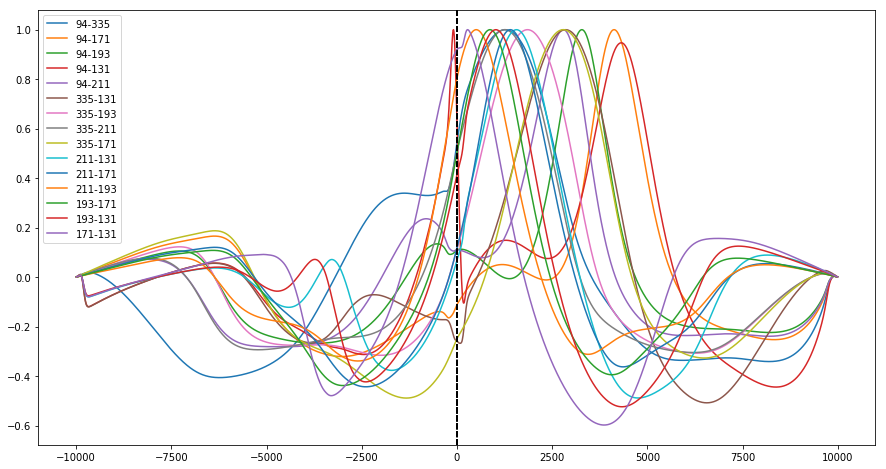

In [12]:
fig = plt.figure(figsize=(15,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs,):
    # cooling
    cc = tl.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl.timelags,cc/cc.max(), color=f'C{i%10}', ls='-', label='{}-{}'.format(*p))
    ax.axvline(x=0,ls='--',color='k')
#axes[0,0].set_xlim([-5e3,5e3])
ax.legend(loc=2)

Now, compute the timelag and correlation maps for all of the channel pairs.

In [9]:
timelag_bounds = (-6*u.hour,6*u.hour)

In [10]:
timelag_maps = {}
correlation_maps = {}
with ProgressBar(len(channel_pairs),ipython_widget=True) as prog:
    for p in channel_pairs:
        timelag_maps['{}-{}'.format(*p)] = tl.make_timelag_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds)
        correlation_maps['{}-{}'.format(*p)] = tl.make_correlation_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds, )
        prog.update()

FloatProgress(value=0.0)

And plot the maps.

In [17]:
correlation_threshold = 0.5

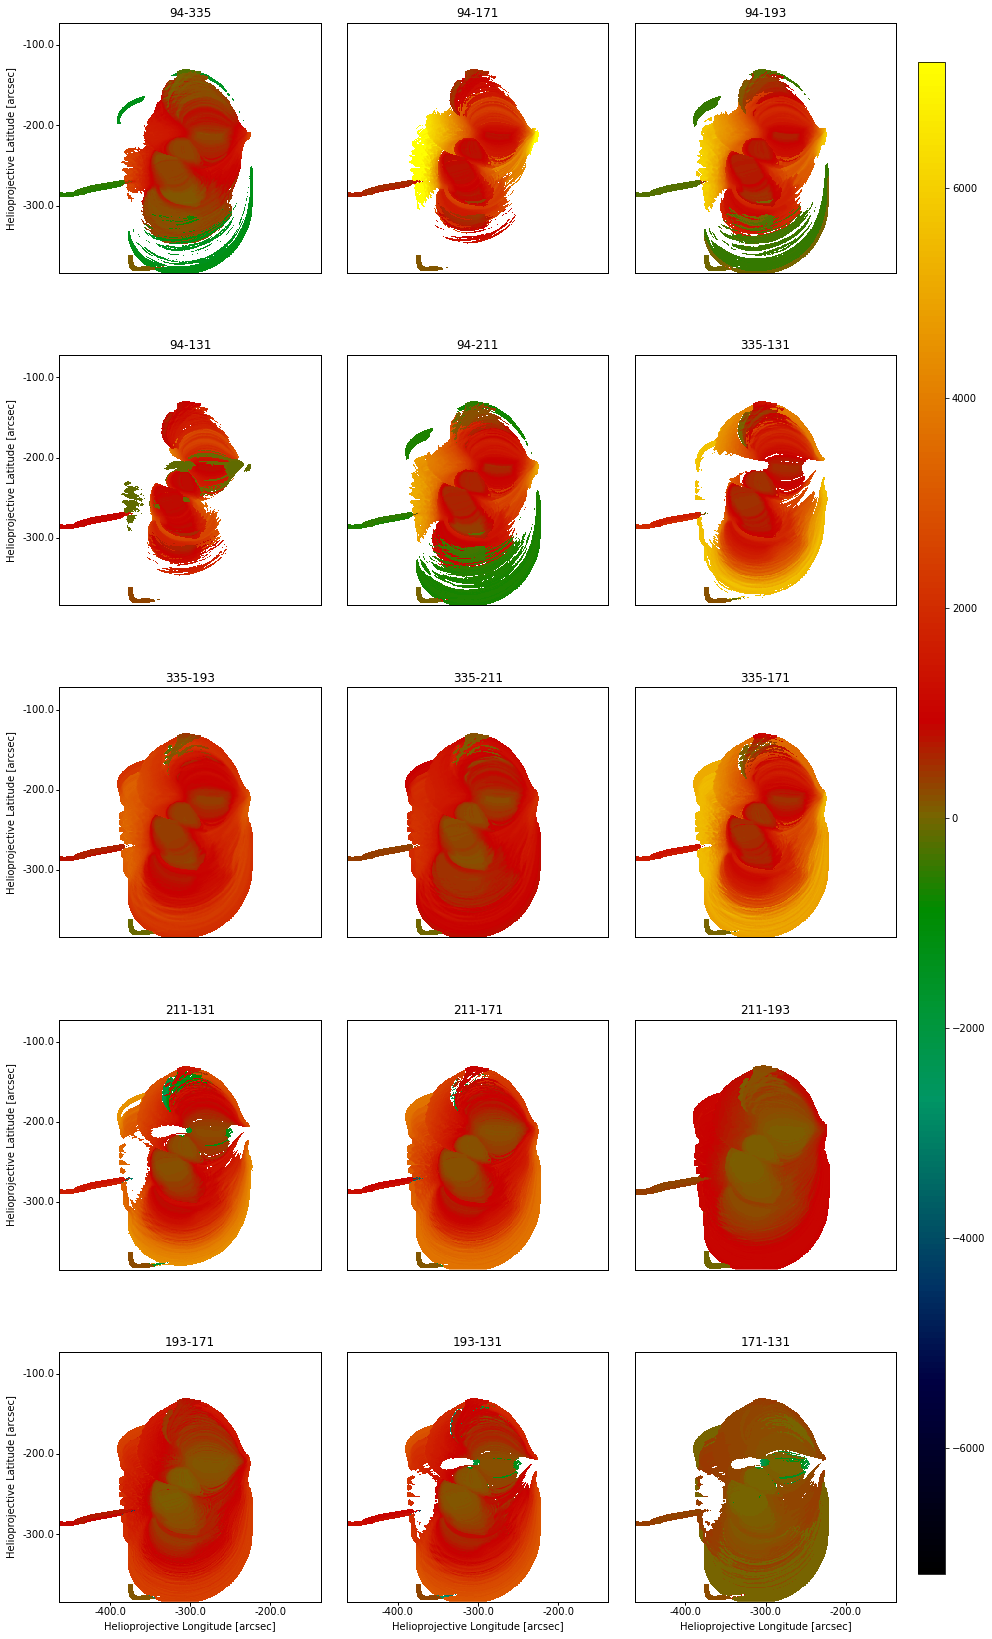

In [18]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = Map(timelag_maps['{}-{}'.format(*cp)])
    mc = Map(correlation_maps['{}-{}'.format(*cp)])
    m = Map(m.data, m.meta, mask=np.where(mc.data<=correlation_threshold, True, False))
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 11:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

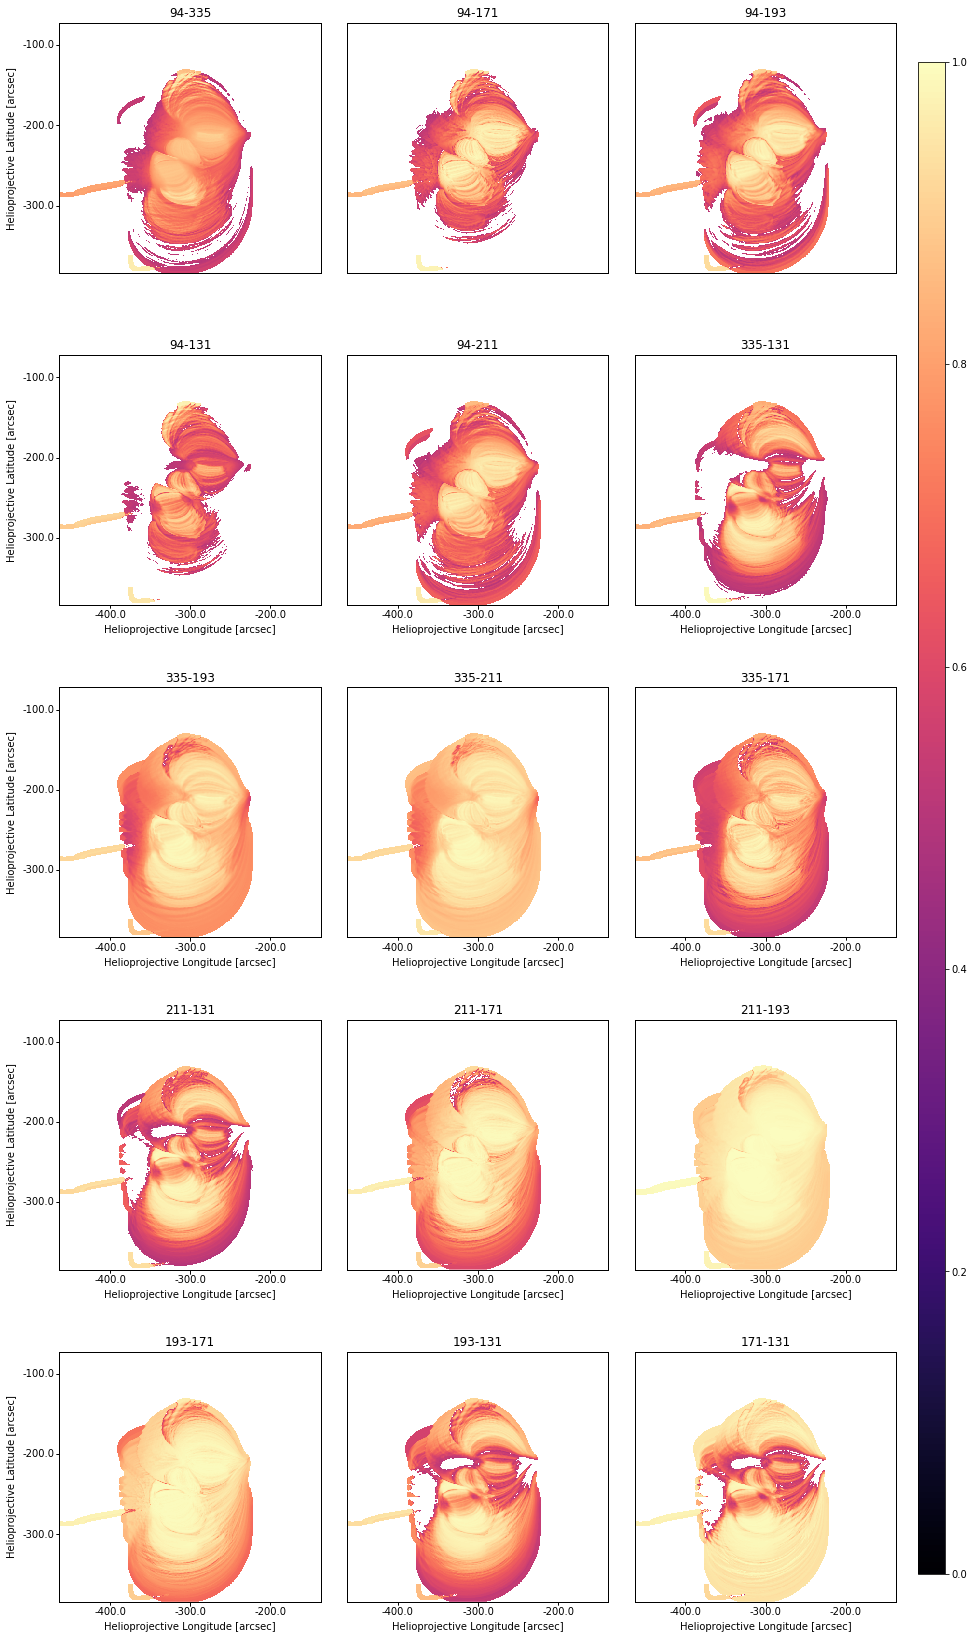

In [19]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    m = Map(m.data,m.meta,mask=np.where(m.data < correlation_threshold, True, False))
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=1, cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

Finally, we want to save the maps for all of the channel pairs so that we can analyze them later.

In [20]:
# save maps here
fitsfile = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}/nei/timelags/{type}_{c0}_{c1}.fits'
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency='cooling', type='timelag', c0=p[0], c1=p[1]))
    correlation_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency='cooling', type='correlation', c0=p[0], c1=p[1]))